# FACE DETECTOR AND RECOGNIZER

In [1]:
import cv2
import numpy as np
import os
import math
from matplotlib import pyplot as plt
from IPython.display import clear_output
%matplotlib inline


def plt_show(image, title=""):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis("off")
    plt.title(title)
    plt.imshow(image, cmap="Greys_r")
    plt.show()
    
class FaceDetector(object):
    def __init__(self, xml_path):
        self.classifier = cv2.CascadeClassifier(xml_path)
    
    def detect(self, image, biggest_only=True):
        scale_factor = 1.2
        min_neighbors = 5
        min_size = (30, 30)
        biggest_only = True
        flags = cv2.CASCADE_FIND_BIGGEST_OBJECT | \
                    cv2.CASCADE_DO_ROUGH_SEARCH if biggest_only else \
                    cv2.CASCADE_SCALE_IMAGE
        faces_coord = self.classifier.detectMultiScale(image,
                                                       scaleFactor=scale_factor,
                                                       minNeighbors=min_neighbors,
                                                       minSize=min_size,
                                                       flags=flags)
        return faces_coord
    
class VideoCamera(object):
    def __init__(self, index=0):
        self.video = cv2.VideoCapture(index)
        self.index = index
        print (self.video.isOpened())

    def __del__(self):
        self.video.release()
    
    def get_frame(self, in_grayscale=False):
        _, frame = self.video.read()
        if in_grayscale:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        return frame

def cut_faces(image, faces_coord):
    faces = []
    
    for (x, y, w, h) in faces_coord:
        w_rm = int(0.3 * w / 2)
        faces.append(image[y: y + h, x + w_rm: x + w - w_rm])
         
    return faces

def normalize_intensity(images):
    images_norm = []
    for image in images:
        is_color = len(image.shape) == 3 
        if is_color:
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images_norm.append(cv2.equalizeHist(image))
    return images_norm

def resize(images, size=(50, 50)):
    images_norm = []
    for image in images:
        if image.shape < size:
            image_norm = cv2.resize(image, size, 
                                    interpolation=cv2.INTER_AREA)
        else:
            image_norm = cv2.resize(image, size, 
                                    interpolation=cv2.INTER_CUBIC)
        images_norm.append(image_norm)

    return images_norm

def normalize_faces(frame, faces_coord):
    faces = cut_faces(frame, faces_coord)
    faces = normalize_intensity(faces)
    faces = resize(faces)
    return faces

def draw_rectangle(image, coords):
    for (x, y, w, h) in coords:
        w_rm = int(0.2 * w / 2) 
        cv2.rectangle(image, (x + w_rm, y), (x + w - w_rm, y + h), 
                              (150, 150, 0), 8)

def collect_dataset():
    images = []
    labels = []
    labels_dic = {}
    people = [person for person in os.listdir("People/")]
    for i, person in enumerate(people):
        labels_dic[i] = person
        for image in os.listdir("People/" + person):
            images.append(cv2.imread("People/" + person + '/' + image, 0))
            labels.append(i)
    return (images, np.array(labels), labels_dic)

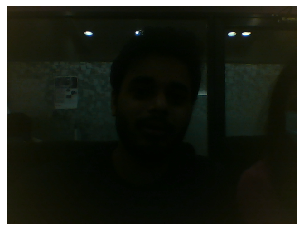

In [2]:
webcam = cv2.VideoCapture(0)
_, frame = webcam.read()
webcam.release()
plt_show(frame) 

In [3]:
detector = cv2.CascadeClassifier("xml/frontal_face.xml")

scale_factor = 1.2
min_neighbors = 5
min_size = (30, 30)
biggest_only = True
flags = cv2.CASCADE_FIND_BIGGEST_OBJECT | \
            cv2.CASCADE_DO_ROUGH_SEARCH if biggest_only else \
            cv2.CASCADE_SCALE_IMAGE
        
faces_coord = detector.detectMultiScale(frame,
                                        scaleFactor=scale_factor,
                                        minNeighbors=min_neighbors,
                                        minSize=min_size,
                                        flags=flags)
print ("Type: " + str(type(faces_coord)))
print (faces_coord)
print ("Length: " + str(len(faces_coord)))

Type: <class 'tuple'>
()
Length: 0


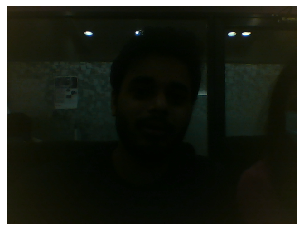

In [4]:
for (x, y, w, h) in faces_coord:
    cv2.rectangle(frame, (x, y), (x + w, y + h), (150, 150, 0), 8)
plt_show(frame) 

In [5]:
webcam = VideoCamera()
detector = FaceDetector("xml/frontal_face.xml")

True


In [6]:
try:
    while True:
        frame = webcam.get_frame()
        faces_coord = detector.detect(frame)
        for (x, y, w, h) in faces_coord:
            cv2.rectangle(frame, (x, y), (x + w, y + h), 
                          (150, 150, 0), 8)
        plt_show(frame) 
        clear_output(wait = True)
except KeyboardInterrupt:
     print ("Video Interrupted")

Video Interrupted


In [7]:
try:
    while True:
        frame = webcam.get_frame()
        faces_coord = detector.detect(frame)
        if len(faces_coord):
            faces = cut_faces(frame, faces_coord)
            faces = normalize_intensity(faces)
            faces = resize(faces)
            plt_show(faces[0])
            clear_output(wait = True)
except KeyboardInterrupt:
     print ("Video Interrupted")

Video Interrupted


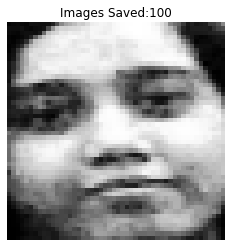

In [8]:
folder = "People/" + input('Person: ').lower() # input name
cv2.namedWindow("Face Recognizer", cv2.WINDOW_AUTOSIZE)
if not os.path.exists(folder):
    os.mkdir(folder)
    counter = 1
    timer = 0
    while counter < 21 : # taking 20 pictures of the people
        frame = webcam.get_frame()
        faces_coord = detector.detect(frame) # detecting 
        if len(faces_coord) and timer % 700 == 50: # every Second or so
            faces = normalize_faces(frame, faces_coord) # norm pipeline
            cv2.imwrite(folder + '/' + str(counter) + '.jpg', faces[0])
            plt_show(faces[0], "Images Saved:" + str(counter))
            clear_output(wait = True) # saved face in notebook
            counter += 1
            
        draw_rectangle(frame, faces_coord) # rectangle around face
        cv2.imshow("Face Recognizer", frame) # live feed in external
        cv2.waitKey(50)
        timer += 50
    cv2.destroyAllWindows()
else:
    print ("This name already exists.")

In [9]:
del webcam

In [10]:
images, labels, labels_dic = collect_dataset()

rec_lbph = cv2.face.LBPHFaceRecognizer_create()
rec_lbph.train(images, labels)

print ("Models Trained Succesfully")

Models Trained Succesfully


In [11]:
detector = FaceDetector("xml/frontal_face.xml")
webcam = VideoCamera(0)

True


In [12]:
cv2.namedWindow("Face Recognizer", cv2.WINDOW_AUTOSIZE)
while True:
    frame = webcam.get_frame()
    faces_coord = detector.detect(frame, True) # detect more than one face
    if len(faces_coord):
        faces = normalize_faces(frame, faces_coord) # norm pipeline
        for i, face in enumerate(faces): # for each detected face
            collector = cv2.face.StandardCollector_create()
            rec_lbph.predict_collect(face, collector)
            conf = collector.getMinDist()
            pred = collector.getMinLabel()
            threshold = 90
            print ("Prediction: " + labels_dic[pred].capitalize() + "\nConfidence: " + str(round(conf)))
            cv2.putText(frame, labels_dic[pred].capitalize(),
                        (faces_coord[i][0], faces_coord[i][1] - 10),
                        cv2.FONT_HERSHEY_PLAIN, 3, (66, 53, 243), 2)
        clear_output(wait = True)
        draw_rectangle(frame, faces_coord) # rectangle around face
    cv2.putText(frame, "ESC to exit", (5, frame.shape[0] - 5),
                    cv2.FONT_HERSHEY_PLAIN, 1.3, (66, 53, 243), 2, cv2.LINE_AA)
    cv2.imshow("Face Recognizer", frame) # live feed in external
    if cv2.waitKey(40) & 0xFF == 27:
        cv2.destroyAllWindows()
        del webcam
        break

Prediction: Shefali
Confidence: 124
